Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
import seaborn as sns
from datetime import datetime
import math

In [3]:
LONG = 20
LAT = 66

data_dir = 'data/tomo/numeric_result/*.json' 


# Create an empty list to store filtered DataFrames
filtered_dfs = []
index=1

# Iterate through all files in the directory
for file_path in glob.glob(data_dir):
    pros=(index/len(glob.glob(data_dir))*100) 
    
    with open(file_path, 'r') as f:

        data = json.load(f)
        df = pd.DataFrame(
            {'lat': data['lat'], 
            'alt': data['alt'],
            'tec': data['ne'],
            'long': data['long']
            })
        df = df.loc[df['long'] == LONG]
        df=df.drop(columns=['long'])
        
        # Check if 't_end' contains only date or both date and time
        if len(data['t_end'][0].split(' ')) == 1:
            df['datetime'] = pd.to_datetime(data['t_end'][0] + ' 00:00:00')
        else:
            df['datetime'] = pd.to_datetime(data['t_end'][0])

        
        # Add the filtered DataFrame to the list
        filtered_dfs.append(df)

        index += 1
    print(f'Reading files... {pros:2f}% done', end='\r')

In [4]:
df = pd.concat(filtered_dfs, ignore_index=True)
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.drop_duplicates(subset=['lat', 'datetime'], keep='first')
df

,lat,alt,tec,datetime
0,55.0,800,0.1558,2023-01-20 10:20:00
1,55.5,800,0.1463,2023-01-20 10:20:00
2,56.0,800,0.1360,2023-01-20 10:20:00
3,56.5,800,0.1250,2023-01-20 10:20:00
4,57.0,800,0.1138,2023-01-20 10:20:00
...,...,...,...,...
2484650,76.0,800,0.0025,2023-01-26 23:40:00
2484651,77.0,800,0.0026,2023-01-26 23:40:00
2484652,78.0,800,0.0027,2023-01-26 23:40:00
2484653,79.0,800,0.0027,2023-01-26 23:40:00


In [5]:
df2 = df.loc[df['datetime'].dt.date == datetime.strptime('2023-01-25', '%Y-%m-%d').date()]
df2

,lat,alt,tec,datetime
1731856,55.0,800,0.0372,2023-01-25 00:00:00
1731857,55.5,800,0.0317,2023-01-25 00:00:00
1731858,56.0,800,0.0259,2023-01-25 00:00:00
1731859,56.5,800,0.0199,2023-01-25 00:00:00
1731860,57.0,800,0.0139,2023-01-25 00:00:00
...,...,...,...,...
2109590,76.0,800,0.0010,2023-01-25 23:55:00
2109591,77.0,800,0.0012,2023-01-25 23:55:00
2109592,78.0,800,0.0015,2023-01-25 23:55:00
2109593,79.0,800,0.0018,2023-01-25 23:55:00


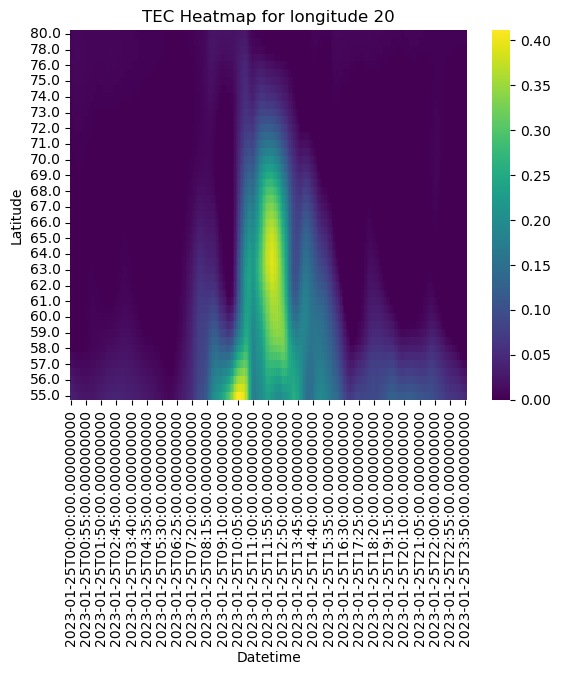

In [6]:
pivot = df2.pivot(index='lat', columns='datetime', values='tec')
sns.heatmap(pivot, cmap='viridis')

plt.xlabel('Datetime')
plt.ylabel('Latitude')
plt.title(f'TEC Heatmap for longitude {LONG}')
plt.gca().invert_yaxis()

plt.show()

In [15]:
rolling_df = pd.DataFrame()

for lat in df2['lat'].unique():
    df5 = df2.loc[df2['lat'] == lat]
    moving_avg = df5['tec'].rolling(window=18, min_periods=1, center=True).mean()
    rolling_df = pd.concat([rolling_df, moving_avg], axis=0)

df2 = pd.concat([df2, rolling_df], axis=1)
df2['rolling'] = df2[0]
df2 = df2.drop(columns=[0])

In [16]:
df2['detrended_tec'] = df2['tec'] - df2['rolling']
df2['detrended_tec'].describe()

count    13536.000000
mean        -0.000006
std          0.011068
min         -0.084439
25%         -0.001100
50%         -0.000036
75%          0.000611
max          0.065328
Name: detrended_tec, dtype: float64

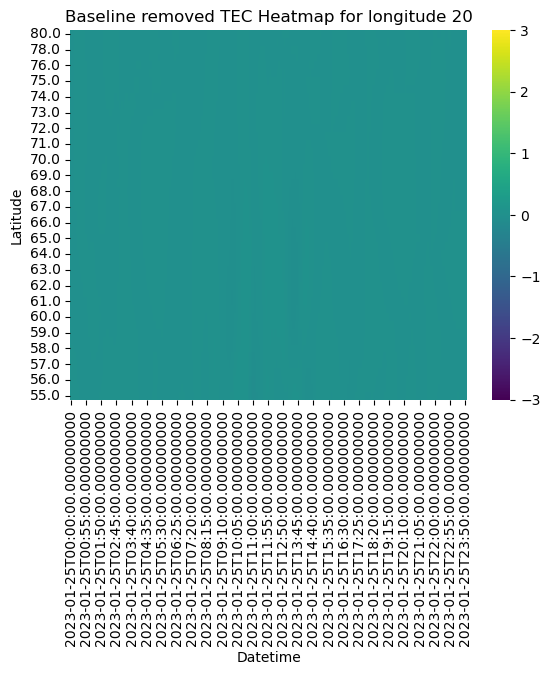

In [17]:
pivot1 = df2.pivot(index='lat', columns='datetime', values='detrended_tec')
sns.heatmap(pivot1, cmap='viridis')

plt.gca().invert_yaxis()
plt.xlabel('Datetime')
plt.ylabel('Latitude')
plt.title(f'Baseline removed TEC Heatmap for longitude {LONG}')

plt.show()

In [18]:
# path2 = 'data/ruots/gotaland.csv'
path2 = 'data/ruots/norra_norrland.csv'
# path2 = 'data/ruots/sodra_norrland.csv'
# path2 = 'data/ruots/svealand.csv'


dfv = pd.read_csv(path2, header=None, sep=';')
DT1, DT2 = df2['datetime'].unique()[0], df2['datetime'].unique()[-1]
dfv['datetime'] = pd.to_datetime(dfv[0])
dfv['i95'] = dfv[1].str.replace(',', '.').astype(float)
dfv.drop([0, 1], axis=1, inplace=True)
dfv = dfv.loc[(dfv['datetime'] >= DT1) & (dfv['datetime'] <= DT2)]

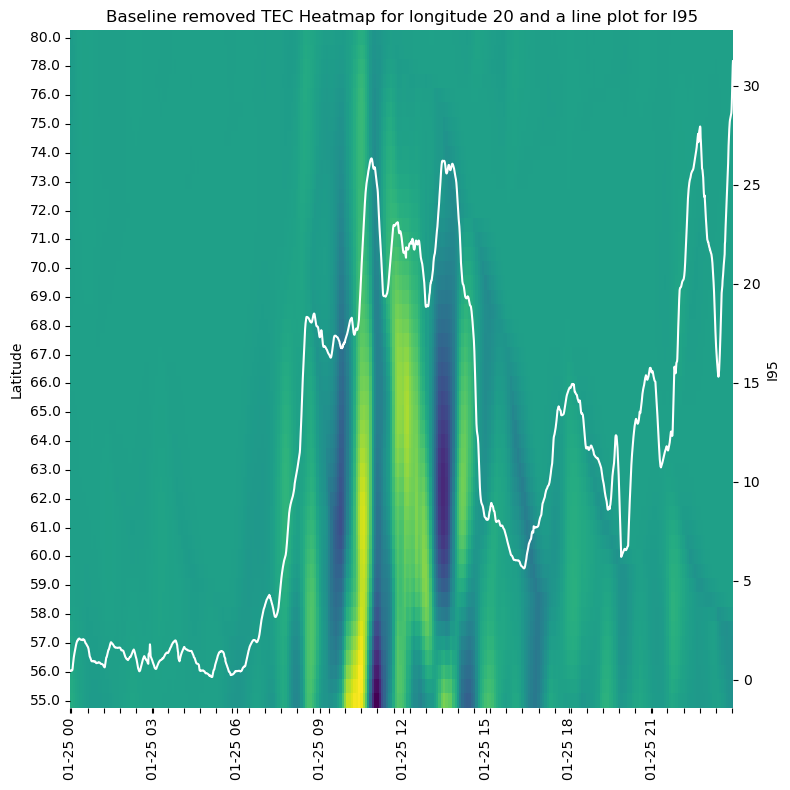

In [19]:
check = False
indices = [len(df2['datetime'].unique().tolist())/6*i for i in range(1,6)]
checklist = [str(df2['datetime'].unique().tolist()[math.ceil(index)]) for index in indices]


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

pivot2 = df2.pivot(index='lat', columns='datetime', values='detrended_tec')

min_x = df2['datetime'].min()
max_x = df2['datetime'].max()

ax.set_xlim(min_x, max_x)
g1 = sns.heatmap(pivot2, cmap='viridis', ax=ax, cbar=False)
ax.invert_yaxis()
g1.set(xlabel=None, ylabel = 'Latitude', 
title = f'Baseline removed TEC Heatmap for longitude {LONG} and a line plot for I95')
ax.set_xticklabels([])

if check:
    for date in checklist:

        x = df2['datetime'].unique().tolist().index(datetime.strptime(date, '%Y-%m-%d %H:%M:%S'))
        ax.axvline(x=x, color='red', lw=5)


ax2 = fig.add_subplot(111)
ax2.plot(dfv['datetime'], dfv['i95'], color='white', zorder=10, lw=1.5)
ax2.yaxis.set_label_text('I95')
plt.xticks(rotation =90)
ax2.set_xlim(min_x, max_x)
ax2.yaxis.tick_right()
ax2.grid(False)
ax2.patch.set_alpha(0.0) #type: ignore
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_label_position("right")

if check:
    for date in checklist:
        ax2.axvline(x=np.datetime64(date).tolist(), color='black', zorder=5, lw=1)


plt.tight_layout()

plt.show()

In [20]:
df3 = df2.loc[(df2['lat'] == LAT)]

moving_avg = df5['tec'].rolling(window=18, min_periods=1, center=True).mean()

# Subtract the moving average from the original values
df5['detrended_tec'] = df5['tec'] - moving_avg
df5


,lat,alt,tec,datetime,rolling,detrended_tec
1731902,80.0,800,0.0047,2023-01-25 00:00:00,0.006156,-0.001956
1733218,80.0,800,0.0054,2023-01-25 00:05:00,0.006095,-0.001260
1734534,80.0,800,0.0063,2023-01-25 00:10:00,0.006035,-0.000336
1735850,80.0,800,0.0070,2023-01-25 00:15:00,0.005981,0.000408
1737166,80.0,800,0.0074,2023-01-25 00:20:00,0.005932,0.000869
...,...,...,...,...,...,...
2104330,80.0,800,0.0024,2023-01-25 23:35:00,0.002587,0.000000
2105646,80.0,800,0.0023,2023-01-25 23:40:00,0.002568,-0.000077
2106962,80.0,800,0.0023,2023-01-25 23:45:00,0.002552,-0.000050
2108278,80.0,800,0.0022,2023-01-25 23:50:00,0.002535,-0.000127


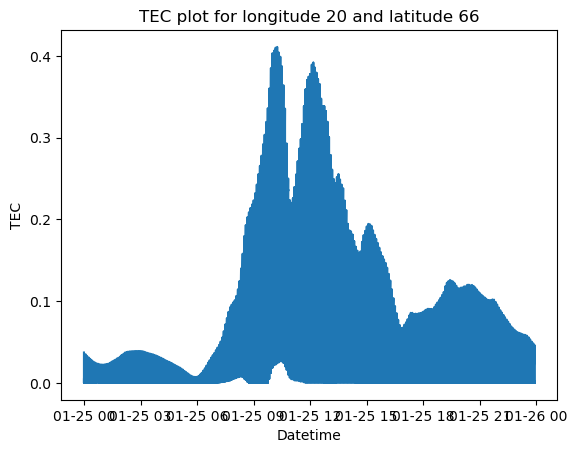

In [21]:
plt.plot(df2['datetime'], df2['tec'])
#plt.plot(df5.index, moving_avg)
plt.xlabel('Datetime')
plt.ylabel('TEC')
plt.title(f'TEC plot for longitude {LONG} and latitude {LAT}')
plt.show()

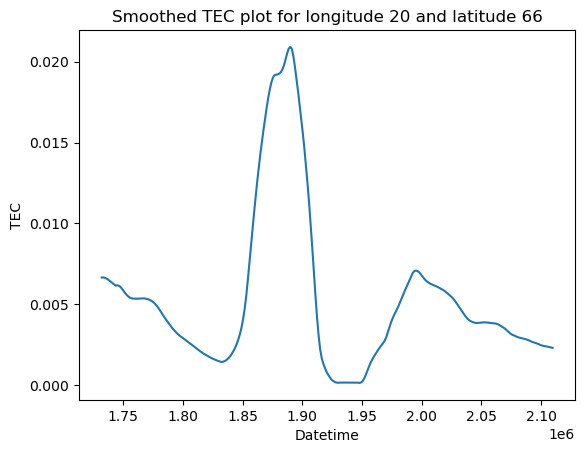

In [22]:
plt.plot(df5.index, moving_avg)
plt.xlabel('Datetime')
plt.ylabel('TEC')
plt.title(f'Smoothed TEC plot for longitude {LONG} and latitude {LAT}')
plt.show()